In [137]:
import pandas as pd
import torch
import torch.nn as nn
import torch.distributions as dist
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm

In [138]:
df = pd.read_csv('data/rnn_wild_type_added.csv')

df[['time_at_birth']] = (df[['time_at_birth']] - 12) % 24
print(df.head())


   cell  flour_at_birth  flour_at_divide  time_at_birth  time_difference  \
0     1          401.81           439.44          20.25            12.00   
1     1          416.27           315.98           8.25            12.00   
2     1          331.07           478.18          20.25            12.00   
3     1          440.67           326.06           8.25             9.00   
4     2          453.93           404.42          20.25            11.25   

   original_size  added_size  
0         44.362      47.287  
1         45.371      60.769  
2         53.088      62.292  
3         57.672      50.378  
4         47.034      47.238  


   cell  flour_at_birth  flour_at_divide  time_at_birth  time_difference  \
0     1        0.417921         0.824015       1.328220         0.353255   
1     1        0.627931        -0.848976      -0.708955         0.353255   
2     1       -0.609472         1.348976       1.328220         0.353255   
3     1        0.982304        -0.712383      -0.708955        -0.494449   
4     2        1.174886         0.349463       1.328220         0.141329   

   original_size  added_size  
0      -0.517086   -0.210025  
1      -0.402039    0.610180  
2       0.477856    0.702835  
3       1.000525   -0.021978  
4      -0.212423   -0.213006  
Average sequence length: 5.89


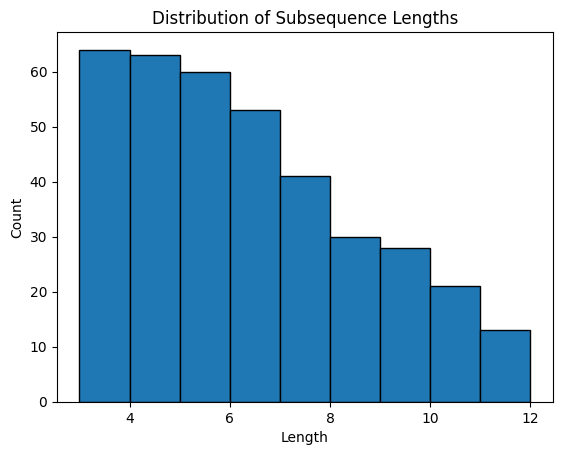

In [159]:
features = ['flour_at_birth', 'flour_at_divide', 'time_at_birth',
            'time_difference', 'original_size', 'added_size']

means = df[features].mean()
stds = df[features].std()

df_scaled = df.copy()
df_scaled[features] = (df[features] - means) / stds

print(df_scaled.head())

sequences = []
extra = []
target = []
sizes = []
for cell_id, group in df_scaled.groupby('cell'):
    group_tensor = torch.tensor(group[[
        'flour_at_birth', 'flour_at_divide', 'time_at_birth',
        'time_difference', 'original_size', 'added_size'
    ]].values, dtype=torch.float32)

    num_steps = group_tensor.size(0)

    for i in range(3, num_steps):
        seq_data = group_tensor[:i]
        extra_data = group_tensor[i, [0,2,4]]
        target_data = group_tensor[i, [3, 5]]

        sequences.append(seq_data)
        extra.append(extra_data)
        target.append(target_data)

    sizes.append(num_steps)

extra = torch.stack(extra)
target = torch.stack(target)

sequence_lengths = [seq.shape[0] for seq in sequences]
average_length = sum(sequence_lengths) / len(sequence_lengths)
print(f"Average sequence length: {average_length:.2f}")

plt.hist(sequence_lengths, bins=range(min(sequence_lengths), max(sequence_lengths) + 1), edgecolor='black')
plt.title("Distribution of Subsequence Lengths")
plt.xlabel("Length")
plt.ylabel("Count")
plt.show()



In [ ]:
class SequenceDataset(Dataset):
    def __init__(self, sequences, extra, target):
        self.sequences = sequences
        self.extras = extra
        self.targets = target

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return (
            self.sequences[idx],  
            self.extras[idx],     
            self.targets[idx]     
        )


In [141]:
def collate_fn(batch):
    sequences, extra, target = zip(*batch)
    padded_sequences = pad_sequence(sequences, batch_first=True,
                                    padding_value=0)
    mask = (padded_sequences != 0).float()

    extra = torch.stack(extra)
    target = torch.stack(target)

    return padded_sequences, mask, extra, target

In [ ]:
full_dataset = SequenceDataset(sequences, extra, target)

total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size  

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  
)

train_dataloader = DataLoader(train_dataset, batch_size=16,
                              shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=16,
                              shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=16,
                              shuffle=False, collate_fn=collate_fn)

In [ ]:
class RNNEncoderTwoHeads(nn.Module):
    def __init__(self, input_dim=6, history_dim=16):
        super().__init__()
        self.rnn = nn.RNN(input_dim, history_dim, batch_first=True)
        self.regression_head = nn.Linear(history_dim + 3, 2)

    def forward(self, padded_sequences, mask, extra):
        lengths = torch.tensor([int(m.sum()/6) for m in mask])
        packed = pack_padded_sequence(padded_sequences, lengths,
                                      batch_first=True, enforce_sorted=False)
        _, history = self.rnn(packed)
        encoded = history.squeeze(0)  # Shape: [batch_size, hidden_dim]    

        combined = torch.cat([encoded, extra], dim=1)

        output = self.regression_head(combined)
        predicted_time_diff = output[:, 0]
        predicted_added_length = output[:, 1]

        return predicted_time_diff, predicted_added_length



In [ ]:
def mse_loss(pred_time_diff, pred_added_length, target):
    true_time_diff = target[:, 0]
    true_added_length = target[:, 1]

    loss_time = nn.functional.mse_loss(pred_time_diff, true_time_diff)
    loss_length = nn.functional.mse_loss(pred_added_length, true_added_length)

    return loss_time + loss_length  

Epoch 1 Train Loss: 1.9323  Val Loss: 1.6992
Epoch 2 Train Loss: 1.7792  Val Loss: 1.5532
Epoch 3 Train Loss: 1.7099  Val Loss: 1.4454
Epoch 4 Train Loss: 1.6494  Val Loss: 1.3714
Epoch 5 Train Loss: 1.5947  Val Loss: 1.3229
Epoch 6 Train Loss: 1.5913  Val Loss: 1.2774
Epoch 7 Train Loss: 1.5417  Val Loss: 1.2403
Epoch 8 Train Loss: 1.6768  Val Loss: 1.2108
Epoch 9 Train Loss: 1.6012  Val Loss: 1.1901
Epoch 10 Train Loss: 1.5002  Val Loss: 1.1886
Epoch 11 Train Loss: 1.5075  Val Loss: 1.1579
Epoch 12 Train Loss: 1.4812  Val Loss: 1.1451
Epoch 13 Train Loss: 1.5258  Val Loss: 1.1311
Epoch 14 Train Loss: 1.3916  Val Loss: 1.1409
Epoch 15 Train Loss: 1.4633  Val Loss: 1.1285
Epoch 16 Train Loss: 1.3821  Val Loss: 1.1239
Epoch 17 Train Loss: 1.3796  Val Loss: 1.1287
Epoch 18 Train Loss: 1.3808  Val Loss: 1.1444
Epoch 19 Train Loss: 1.4116  Val Loss: 1.1353
Epoch 20 Train Loss: 1.3100  Val Loss: 1.1690
Epoch 21 Train Loss: 1.3078  Val Loss: 1.1658
Epoch 22 Train Loss: 1.2762  Val Loss: 1.19

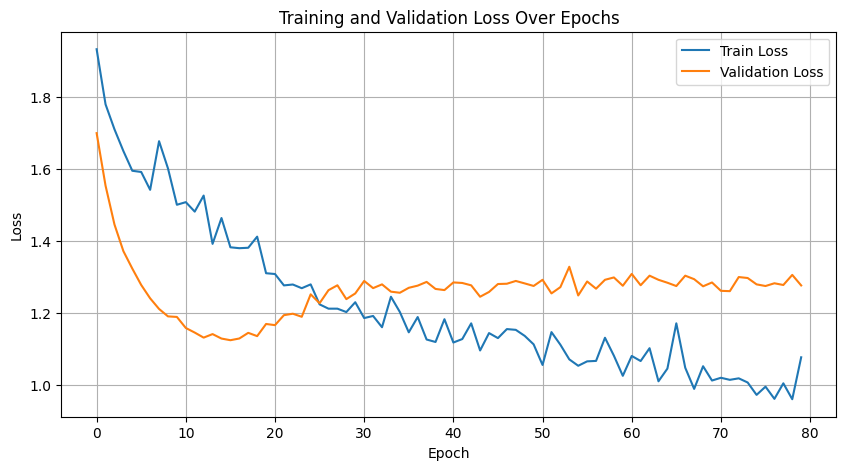

In [145]:
train_losses = []
val_losses = []

model = RNNEncoderTwoHeads()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 80
for epoch in range(num_epochs):
    # Training
    model.train()
    total_train_loss = 0
    for padded_sequences, mask, extra, target in train_dataloader:
        opt.zero_grad()
        pred_time_diff, pred_added_length = model(padded_sequences, mask, extra)
        loss = mse_loss(pred_time_diff=pred_time_diff,
                        pred_added_length=pred_added_length, target=target)
        loss.backward()
        opt.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for padded_sequences, mask, extra, target in val_dataloader:
            pred_time_diff, pred_added_length = model(padded_sequences, mask, extra)
            val_loss = mse_loss(pred_time_diff=pred_time_diff,
                                pred_added_length=pred_added_length, target=target)
            total_val_loss += val_loss.item()
    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} Train Loss: {avg_train_loss:.4f}  Val Loss: {avg_val_loss:.4f}")

# Plot both losses
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [146]:
def unscale(scaled_values, mean, std):
    return scaled_values * std + mean

def rescale(original_values, mean, std):
    return (original_values - mean) / std

4.3893232345581055 13.049600601196289


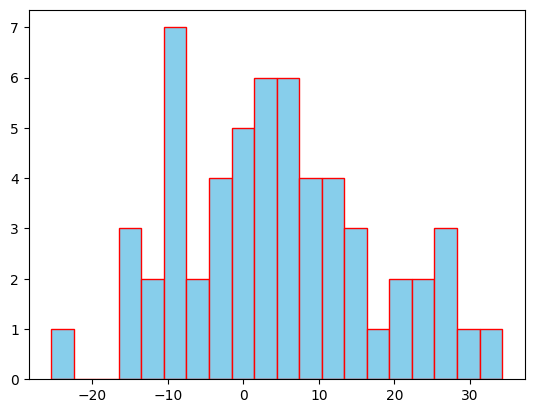

0.9131221175193787 2.763749837875366


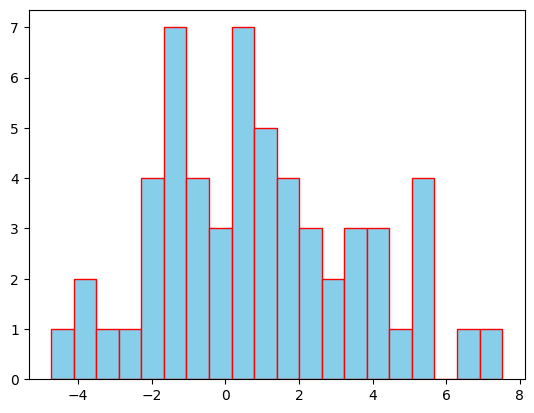

In [ ]:
model.eval()
with torch.no_grad():
    preds_unscaled_time_diffs = []
    preds_unscaled_added_lengths = []
    targets = []
    for padded_sequences, mask, extra, target in test_dataloader: 
        pred_time_diff, pred_added_length = model(padded_sequences, mask, extra)
        pred_time_diff_unscaled = unscale(pred_time_diff, means['time_difference'], stds['time_difference'])
        pred_added_length_unscaled = unscale(pred_added_length, means['added_size'], stds['added_size'])
        preds_unscaled_time_diffs.append(pred_time_diff_unscaled.detach())
        preds_unscaled_added_lengths.append(pred_added_length_unscaled.detach())

        targets.append(target)


preds_unscaled_added_lengths = torch.cat(preds_unscaled_added_lengths, dim=0)
preds_unscaled_time_diffs = torch.cat(preds_unscaled_time_diffs, dim=0)
targets = torch.cat(targets, dim=0)

length_errors = preds_unscaled_added_lengths - unscale(targets[:, 1], means['added_size'], stds['added_size'])
mean = length_errors.mean().item()
std = length_errors.std().item()
print(mean, std)
plt.hist(length_errors, bins=20, color='skyblue', edgecolor='red')
plt.show()

time_errors = preds_unscaled_time_diffs - unscale(targets[:,0], means['time_difference'], stds['time_difference'])
mean = time_errors.mean().item()
std = time_errors.std().item()
print(mean, std)
plt.hist(time_errors, bins=20, color='skyblue', edgecolor='red')
plt.show()


In [148]:
from scipy.optimize import curve_fit

df = pd.read_csv('data/rnn_wild_type_added.csv')

df[['time_at_birth']] = (df[['time_at_birth']] - 12) % 24

data = df[['flour_at_birth', 'time_at_birth']]

def cosine_model(t, A, B, C, D):
    return A * np.cos(B*(t-C)) + D

x_data = data['time_at_birth'].values
y_data = data['flour_at_birth'].values

initial_guess = [100, 2 * np.pi / 24, 12, 400] 

params, _ = curve_fit(cosine_model, x_data, y_data, p0=initial_guess)
A, B, C, D = params
print(f"Fitted Parameters:\nA = {A:.2f}, B = {B:.4f}, C = {C:.2f}, D = {D:.2f}")

Fitted Parameters:
A = -101.43, B = 0.2117, C = 14.46, D = 411.61


In [ ]:
features = ['flour_at_birth', 'flour_at_divide', 'time_at_birth',
            'time_difference', 'original_size', 'added_size']

means = df[features].mean()
stds = df[features].std()

df_scaled = df.copy()
df_scaled[features] = (df[features] - means) / stds

initial_input = []
initial_extra = []
for cell_id, group in df_scaled.groupby('cell'):
    group_tensor = torch.tensor(group[[
        'flour_at_birth', 'flour_at_divide', 'time_at_birth',
        'time_difference', 'original_size', 'added_size'
    ]].values, dtype=torch.float32)

    seq_data = group_tensor[0, :]
    extra_data = group_tensor[1, [0,2,4]]
    initial_input.append(seq_data)
    initial_extra.append(extra_data)

initial_input = torch.stack(initial_input).unsqueeze(0)
initial_extra = torch.stack(initial_extra)

initial_input = initial_input.permute(1, 0, 2)
print(initial_input.shape)
print(initial_extra.shape)

torch.Size([64, 1, 6])
torch.Size([64, 3])


unscaled_time_difference shape: torch.Size([64, 1])
unscaled_time_at_birth shape: torch.Size([64, 1])
flour_at_birth shape: torch.Size([64, 1])
flour_at_divide shape: torch.Size([64, 1])
time_at_birth shape: torch.Size([64, 1])
pred_time_difference shape: torch.Size([64])
original_size shape: torch.Size([64, 1])
pred_added_size shape: torch.Size([64])
input_t shape: torch.Size([64, 1, 6])
extra_t shape: torch.Size([64, 3])
unscaled_time_difference shape: torch.Size([64, 1])
unscaled_time_at_birth shape: torch.Size([64, 1])
flour_at_birth shape: torch.Size([64, 1])
flour_at_divide shape: torch.Size([64, 1])
time_at_birth shape: torch.Size([64, 1])
pred_time_difference shape: torch.Size([64])
original_size shape: torch.Size([64, 1])
pred_added_size shape: torch.Size([64])
input_t shape: torch.Size([64, 1, 6])
extra_t shape: torch.Size([64, 3])
unscaled_time_difference shape: torch.Size([64, 1])
unscaled_time_at_birth shape: torch.Size([64, 1])
flour_at_birth shape: torch.Size([64, 1])
fl

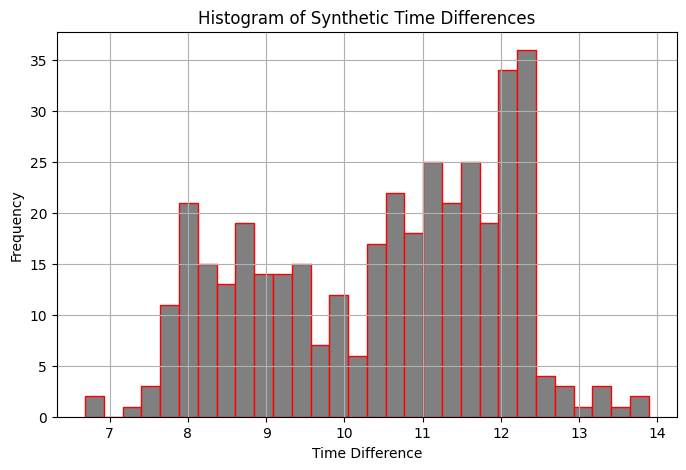

<function matplotlib.pyplot.show(close=None, block=None)>

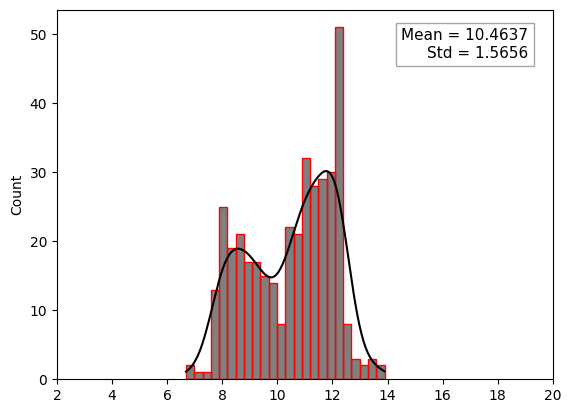

In [ ]:
import math

model.eval()

batch_size = 64
input_dim = 6
sequence_length_to_generate = 7


hidden = None  # start hidden state as zeros internally in RNN

input_t = initial_input  # shape (batch_size, 1, input_dim)
extra_t = initial_extra  # shape (batch_size, 3)

generated_outputs = [input_t.squeeze(0)]

flour_at_birth = initial_extra[:, 0].view(64,1)
time_at_birth = initial_extra[:, 1].view(64,1)
original_size = initial_extra[:, 2].view(64,1)

#print(flour_at_birth)

for _ in range(sequence_length_to_generate):
    with torch.no_grad():
        pred_time_difference, pred_added_size = model(input_t, mask = torch.ones_like(input_t), extra=extra_t)
    
    unscaled_time_difference = unscale(pred_time_difference, means['time_difference'], stds['time_difference']).view(-1,1)
    unscaled_added_size = unscale(pred_added_size, means['added_size'], stds['added_size']).view(-1,1)

    # next_input is flour_at_birth, flour_at_divide, time_at_birth, time_differnce, original_size, added_size, we have already flour_at_birth, time_at_birth, original_size
    # time_difference is predicted time_difference
    # added_size is predicted added_size
    # need flour_at_divide = 425.0050 + 127.5510*cos(0.1955*(time_at_birth + time_difference - 0.75) + 2.5460)
    # extra is flour_at_birth, time_at_birth, original_size
    # extra flour_at_birth = 425.0050 + 127.5510*cos(0.1955*(prev_time_at_birth + time_difference) + 2.5460)
    # extra time_at_birth = (prev time_at_birth + time_difference) % 24
    # extra original size = 0.5 * prev original_size + added_size

    print("unscaled_time_difference shape:", unscaled_time_difference.shape)  # Should be [64, 1]
    # Compute flour_at_divide
    unscaled_time_at_birth = unscale(time_at_birth, means['time_at_birth'], stds['time_at_birth'])
    print("unscaled_time_at_birth shape:", unscaled_time_at_birth.shape)
    unscaled_flour_at_divide = 411.61 - 101.43*torch.cos(0.2117*((unscaled_time_at_birth + unscaled_time_difference - 0.75)%24 - 14.46))
    flour_at_divide = rescale(unscaled_flour_at_divide, means['flour_at_divide'], stds['flour_at_divide'])

    print("flour_at_birth shape:", flour_at_birth.shape)
    print("flour_at_divide shape:", flour_at_divide.shape)
    print("time_at_birth shape:", time_at_birth.shape)
    print("pred_time_difference shape:", pred_time_difference.shape)
    print("original_size shape:", original_size.shape)
    print("pred_added_size shape:", pred_added_size.shape)

    # Build next input
    input_t = torch.stack([
        flour_at_birth.squeeze(1),
        flour_at_divide.squeeze(1),
        time_at_birth.squeeze(1),
        pred_time_difference,
        original_size.squeeze(1),
        pred_added_size
    ], dim=1)  # shape: [64, 6]

    input_t = input_t.unsqueeze(1)  # shape: [64, 1, 6]

    print("input_t shape:", input_t.shape)

    # Update extra
    unscaled_original_size = unscale(original_size, means['original_size'], stds['original_size'])
    unscaled_time_at_birth = (unscaled_time_at_birth + unscaled_time_difference) % 24
    unscaled_flour_at_birth = 411.61 - 101.43*torch.cos(0.2117*(unscaled_time_at_birth - 14.46))
    unscaled_original_size = 0.5 * (unscaled_original_size + unscaled_added_size)
    time_at_birth = rescale(unscaled_time_at_birth, means['time_at_birth'], stds['time_at_birth'])
    flour_at_birth = rescale(unscaled_flour_at_birth, means['flour_at_birth'], stds['flour_at_birth'])
    original_size = rescale(unscaled_original_size, means['original_size'], stds['original_size'])

    extra_t = torch.cat([flour_at_birth, time_at_birth, original_size], dim=1)
    print("extra_t shape:",extra_t.shape)

    generated_outputs.append(input_t.squeeze(0))
    

generated_outputs = torch.stack(generated_outputs, dim=1).squeeze(2)  # (batch_size, seq_len, 2)

means_tensor = torch.tensor(means.values)  # shape: [6]
stds_tensor = torch.tensor(stds.values)    # shape: [6]


generated_outputs_unscaled = unscale(generated_outputs, means_tensor, stds_tensor)

print(generated_outputs_unscaled[0])

time_difference_unscaled = generated_outputs_unscaled[:,2:, 3] # don't include first two vectors in the 64 sequences
print(time_difference_unscaled.shape)
time_diff_flat = time_difference_unscaled.numpy().flatten()


print("mean: ", time_diff_flat.mean())
print("standard deviation: ", time_diff_flat.std())

plt.figure(figsize=(8,5))
plt.hist(time_diff_flat, bins=30, color='gray', edgecolor='red')
plt.title("Histogram of Synthetic Time Differences")
plt.xlabel("Time Difference")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

import seaborn as sns
sns.histplot(time_diff_flat, bins=24, kde=True, color='black', edgecolor='red')
plt.text(0.95, 0.95, f"Mean = {time_diff_flat.mean():.4f}\nStd = {time_diff_flat.std():.4f}",
         horizontalalignment = 'right',
         verticalalignment = 'top',
         transform=plt.gca().transAxes,
         fontsize = 11,
         bbox=dict(facecolor='white', alpha = 0.7, edgecolor= 'gray'))
plt.legend([],[], frameon=False)
plt.xlim(2, 20)
plt.show